In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.feature_selection import RFECV, RFE
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
from statistics import median 
import seaborn as sns
%matplotlib inline

In [2]:
# read training and test set data files
df_train = pd.read_csv('train_features_data.csv')
df_test = pd.read_csv('test_features_data.csv')
y_train = pd.read_csv('train_labels_data.csv')
y_test = pd.read_csv('test_labels_data.csv')

In [6]:
# Train labels array
y = y_train.DECEASED_INDICATOR.values

In [3]:
# select the continous features only
continous_feature = ['AGE','BMI', 'TEMPERATURE', 'TEMP_MAX', 'SYSTOLIC_BP', 'DIASTOLIC_BP', 'O2_SAT', 'O2SAT_MIN'] 
X_train_cont = df_train[continous_feature]

In [6]:
# imputation of continuous features with its mean value by using SimpleImputater libraries
my_imputer = SimpleImputer(strategy = 'mean')
imputed_X_train_cont = pd.DataFrame(my_imputer.fit_transform(X_train_cont),columns = X_train_cont.columns.tolist())

In [7]:
# Used standard scaling to scal all continous features by using standard scaling libraries
ss = StandardScaler()
train_features_ss = pd.DataFrame(ss.fit_transform(imputed_X_train_cont), columns =  imputed_X_train_cont.columns.tolist())

In [8]:
# droped continous variables from dataframe to select categorical variables
columns = X_train_cont.columns.tolist()
X_cate_miss = df_train.drop(columns,axis =1)

In [9]:
# imputation categorical features by its mode value
my_imputer_mf = SimpleImputer(strategy = "most_frequent")
imputed_X_train_cate = pd.DataFrame(my_imputer_mf.fit_transform(X_cate_miss),columns = X_cate_miss.columns.tolist())

In [10]:
#  concatination of all continous, categorical features after imputation
df_train = pd.concat([train_features_ss,imputed_X_train_cate], axis=1)

In [11]:
# Finding highly correlated features (>0.90) 
# Create correlation matrix
corr_matrix = df_train.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

In [12]:
# droped highly correlated features from dataframe
df_train =  df_train.drop(to_drop , axis=1 )

In [15]:
# following function calculate Precision, Recall, F1-score Accuracy etc 
def precision_recall_fscore(val_labels, y_score_lr, thresholds):
    Precision_0 = []
    Recall_0 = []
    F1_scores_0 = []  
    Tn= []
    Fp= []
    Fn= []
    Tp= []
    Accu = []
    
    for i in range(0,len(thresholds)):
        y_score_lr_binary = (y_score_lr >= thresholds[i]).astype('int')
        tn, fp, fn, tp = confusion_matrix(val_labels, y_score_lr_binary).ravel()
        precision_0 = tn/(tn+fn)
        recall_0 = tn/(tn+fp)
        accu = (tp + tn)/(tp + tn + fp + fn)
        f1_scores_0 = 2*(precision_0*recall_0)/(precision_0+recall_0)
        Precision_0.append(precision_0)
        Recall_0.append(recall_0)
        F1_scores_0.append(f1_scores_0)
        Tn.append(tn)
        Fp.append(fp)
        Fn.append(fn)
        Tp.append(tp)
        Accu.append(accu)
    return(Precision_0, Recall_0, F1_scores_0,Tn, Fp, Fn, Tp, Accu )

In [ ]:
F_max_rf_final = []
P_max_rf_final = []
R_max_rf_final = []
thres_rf_final = []
AU_PRC_rf_final = []
AUC_rf_final = []
Accu_rf_final = []

F_max_lr_final=[]
P_max_lr_final=[]
R_max_lr_final=[]
thres_lr_final = []
AU_PRC_lr_final=[]
AUC_lr_final = []
Accu_lr_final = []

F_max_svm_final = []
P_max_svm_final = []
R_max_svm_final = []
thres_svm_final = []
AU_PRC_svm_final = []
AUC_svm_final = []
Accu_svm_final = []

F_max_xgb_final = []
P_max_xgb_final = []
R_max_xgb_final = []
thres_xgb_final = []
AU_PRC_xgb_final= []
AUC_xgb_final= []
Accu_xgb_final = []
##########################

F_max_rf_final_0 = []
P_max_rf_final_0 = []
R_max_rf_final_0 = []
AU_PRC_rf_final_0 = []

F_max_lr_final_0=[]
P_max_lr_final_0=[]
R_max_lr_final_0=[]
AU_PRC_lr_final_0=[]

F_max_svm_final_0 = []
P_max_svm_final_0 = []
R_max_svm_final_0 = []
AU_PRC_svm_final_0 = []

F_max_xgb_final_0 = []
P_max_xgb_final_0 = []
R_max_xgb_final_0 = []
AU_PRC_xgb_final_0= []

# split the data 100 times in tratified manner so that distribution of minority class remains uniform in both data sets
# split data in 75% and 25% ratios
for i in range(0,100):
    train_features, val_features, train_labels, val_labels = train_test_split(df_train,y,test_size=0.25,stratify = y)   
    print(i)
    
    F_max_rf = []
    P_max_rf = []
    R_max_rf = []
    thres_rf = []
    AU_PRC_rf = []
    AUC_rf = []
    Accu_rf = []
    
    F_max_lr = []
    P_max_lr = []
    R_max_lr = []
    thres_lr = []
    AU_PRC_lr = []
    AUC_lr = []
    Accu_lr = []
    
    F_max_svm = []
    P_max_svm = []
    R_max_svm = []
    thres_svm = []
    AU_PRC_svm = []
    AUC_svm = []
    Accu_svm = []
    
    F_max_xgb = []
    P_max_xgb = []
    R_max_xgb = []
    thres_xgb = []
    AU_PRC_xgb= []
    AUC_xgb= []
    Accu_xgb = []
#########################
    
    F_max_rf_0 = []
    P_max_rf_0 = []
    R_max_rf_0 = []
    AU_PRC_rf_0 = []
    
    F_max_lr_0 = []
    P_max_lr_0 = []
    R_max_lr_0 = []
    AU_PRC_lr_0 = []
    
    F_max_svm_0 = []
    P_max_svm_0 = []
    R_max_svm_0 = []
    AU_PRC_svm_0 = []

    F_max_xgb_0 = []
    P_max_xgb_0 = []
    R_max_xgb_0 = []
    AU_PRC_xgb_0= []
  
    
    for j in range(0,61,5):# (0,61,5)
        
        # drop columns with missing  0,5,10,15,20,25....,60 % values
        train_features_cutoff = train_features[train_features.columns[(train_features.isna().mean().round(4) * 100 <=j)].tolist()]
        val_features_cutoff = val_features[train_features.columns[(train_features.isna().mean().round(4) * 100 <=j)].tolist()]

        # select the continous features of training set and validation set
        train_features_cont = train_features_cutoff[list(set(train_features_cutoff.columns.tolist()) & set(continous_feature))]
        val_features_cont = val_features_cutoff[list(set(val_features_cutoff.columns.tolist()) & set(continous_feature))]

        # select the categorical features of training set and validation set
        train_features_cate = train_features_cutoff[list(set(train_features_cutoff.columns.tolist()) & set(X_cate_miss.columns.tolist()))]
        val_features_cate = val_features_cutoff[list(set(val_features_cutoff.columns.tolist()) & set(X_cate_miss.columns.tolist()))]

    ############## Mean Mode imputation ####################################################
       # imputation continous by taking mean value of respective continous feature
        my_imputer = SimpleImputer(strategy = 'mean')
        imputed_train_features_cont = pd.DataFrame(my_imputer.fit_transform(train_features_cont),columns =train_features_cont.columns.tolist())
        imputed_val_features_cont = pd.DataFrame(my_imputer.transform(val_features_cont),columns =val_features_cont.columns.tolist())

        # imputation categorical by taking mode value of respective continous feature
        my_imputer_mf = SimpleImputer(strategy = "most_frequent")
        imputed_X_train_cate = pd.DataFrame(my_imputer_mf.fit_transform(train_features_cate),columns = train_features_cate.columns.tolist())
        imputed_X_val_cate = pd.DataFrame(my_imputer_mf.transform(val_features_cate),columns =val_features_cate.columns.tolist())

        ################## concating all continous, categorical features after imputation
        train_features_final = pd.concat([imputed_train_features_cont,imputed_X_train_cate], axis=1)
        val_features_final = pd.concat([imputed_val_features_cont,imputed_X_val_cate], axis=1)

 ##########################################################################################
 # used Random Forest classifier on imputed features    
        rf = RandomForestClassifier()
        rf.fit(train_features_final, train_labels)
        y_pred = rf.predict(val_features_final)
        y_score_rf =rf.predict_proba(val_features_final)[:,1] # calculation probability of class 1
        y_score_rf_0 =rf.predict_proba(val_features_final)[:,0] # calculation probability of class 0
    #####################    
        precision, recall, thresholds = precision_recall_curve(val_labels, y_score_rf)
        thresholds = np.append(thresholds, 1)
        # calculate precision-recall AUC for class 1
        auc = metrics.auc(recall, precision)
        f1_scores = 2*(precision*recall)/(precision+recall)
        Precision_0, Recall_0, F1_scores_0, tn, fp, fn, tp, accu = precision_recall_fscore(val_labels,  y_score_rf, thresholds)
        scrs = pd.DataFrame({'precision' : precision, 
                             'recal' : recall, 
                             'thresholds' : thresholds, 
                             'f1_score':f1_scores, 
                             'precision_0' : Precision_0, 
                             'recal_0' : Recall_0,
                             'f1_score_0':F1_scores_0,
                             'Accu':accu,
                             'tn' : tn, 
                             'fp' :fp, 
                             'fn' :fn, 
                             'tp' :tp})
        fpr, tpr, th = metrics.roc_curve(val_labels, y_score_rf, pos_label = 1)
        auc_rf = metrics.auc(fpr, tpr)  
        
        # calculate precision-recall AUC for class 0
        precision_0, recall_0, thresholds_0 = precision_recall_curve(val_labels, y_score_rf_0, pos_label = 0)
        auc_0 = metrics.auc(recall_0, precision_0)

        f1_score  = scrs.f1_score.max() # find max f-score from scrs dataframe
        Precision = scrs.loc[scrs['f1_score'].idxmax()][0]
        Recall    = scrs.loc[scrs['f1_score'].idxmax()][1]
        Thresolds = scrs.loc[scrs['f1_score'].idxmax()][2]
        AUC       =  auc

        Precision_0 = scrs.loc[scrs['f1_score'].idxmax()][4]
        Recall_0    = scrs.loc[scrs['f1_score'].idxmax()][5]
        f1_score_0 = scrs.loc[scrs['f1_score'].idxmax()][6]
        accu = scrs.loc[scrs['f1_score'].idxmax()][7]
        AUC_0       =  auc_0
       
        #append calculated data of class 1        
        F_max_rf.append(f1_score)
        P_max_rf.append(Precision)
        R_max_rf.append(Recall)
        thres_rf.append(Thresolds)
        AU_PRC_rf.append(AUC)
        AUC_rf.append(auc_rf)
        Accu_rf.append(accu)
        #append calculated data of class 0         
        F_max_rf_0.append(f1_score_0)
        P_max_rf_0.append(Precision_0)
        R_max_rf_0.append(Recall_0)
        AU_PRC_rf_0.append(AUC_0)
    
    
    #############################################
    # used Logistic Regression classifier on imputed features  
        lr = LogisticRegression() 
        lr.fit(train_features_final, train_labels)
        y_pred_lr = lr.predict(val_features_final)
        y_score_lr =lr.predict_proba(val_features_final)[:,1] # calculation probability of class 1
        y_score_lr_0 =lr.predict_proba(val_features_final)[:,0] # calculation probability of class 0

        precision, recall, thresholds = precision_recall_curve(val_labels, y_score_lr)
        thresholds = np.append(thresholds, 1)
        # calculate precision-recall AUC for class 1
        auc = metrics.auc(recall, precision)
        f1_scores = 2*(precision*recall)/(precision+recall)
        Precision_0, Recall_0, F1_scores_0, tn, fp, fn, tp, accu = precision_recall_fscore(val_labels,  y_score_lr, thresholds)
        scrs = pd.DataFrame({'precision' : precision, 
                             'recal' : recall, 
                             'thresholds' : thresholds, 
                             'f1_score':f1_scores, 
                             'precision_0' : Precision_0, 
                             'recal_0' : Recall_0,
                             'f1_score_0':F1_scores_0,
                             'Accu':accu,
                             'tn' : tn, 
                             'fp' :fp, 
                             'fn' :fn, 
                             'tp' :tp})
        fpr, tpr, th = metrics.roc_curve(val_labels, y_score_lr, pos_label = 1)
        auc_lr = metrics.auc(fpr, tpr)  
        
        # calculate precision-recall AUC for zero class
        precision_0, recall_0, thresholds_0 = precision_recall_curve(val_labels, y_score_lr_0, pos_label = 0)
        auc_0 = metrics.auc(recall_0, precision_0)

        f1_score  = scrs.f1_score.max() # find max f-score from scrs dataframe
        Precision = scrs.loc[scrs['f1_score'].idxmax()][0]
        Recall    = scrs.loc[scrs['f1_score'].idxmax()][1]
        Thresolds = scrs.loc[scrs['f1_score'].idxmax()][2]
        AUC       =  auc

        Precision_0 = scrs.loc[scrs['f1_score'].idxmax()][4]
        Recall_0    = scrs.loc[scrs['f1_score'].idxmax()][5]
        f1_score_0 = scrs.loc[scrs['f1_score'].idxmax()][6]
        accu = scrs.loc[scrs['f1_score'].idxmax()][7]
        AUC_0       =  auc_0
  
        #append calculated data of class 1    
        F_max_lr.append(f1_score)
        P_max_lr.append(Precision)
        R_max_lr.append(Recall)
        thres_lr.append(Thresolds)
        AU_PRC_lr.append(AUC)
        AUC_lr.append(auc_lr)
        Accu_lr.append(accu)
        #append calculated data of class 0         
        F_max_lr_0.append(f1_score_0)
        P_max_lr_0.append(Precision_0)
        R_max_lr_0.append(Recall_0)
        AU_PRC_lr_0.append(AUC_0)        

    #############################################
    # used support vector machine classifier on imputed features  
        clf = SVC(gamma='auto',probability=True)
        clf.fit(train_features_final, train_labels)
        y_pred_svm = clf.predict(val_features_final)
        y_score_svm =clf.predict_proba(val_features_final)[:,1] # calculation probability of class 1
        y_score_svm_0 =clf.predict_proba(val_features_final)[:,0] # calculation probability of class 0

        precision, recall, thresholds = precision_recall_curve(val_labels, y_score_svm)
        thresholds = np.append(thresholds, 1)
        # calculate precision-recall AUC for class 1
        auc = metrics.auc(recall, precision)
        f1_scores = 2*(precision*recall)/(precision+recall)
        Precision_0, Recall_0, F1_scores_0, tn, fp, fn, tp, accu = precision_recall_fscore(val_labels,  y_score_svm, thresholds)
        scrs = pd.DataFrame({'precision' : precision, 
                             'recal' : recall, 
                             'thresholds' : thresholds, 
                             'f1_score':f1_scores, 
                             'precision_0' : Precision_0, 
                             'recal_0' : Recall_0,
                             'f1_score_0':F1_scores_0,
                             'Accu':accu,
                             'tn' : tn, 
                             'fp' :fp, 
                             'fn' :fn, 
                             'tp' :tp})
        fpr, tpr, th = metrics.roc_curve(val_labels, y_score_svm, pos_label = 1)
        auc_svm = metrics.auc(fpr, tpr)  
        
        # calculate precision-recall AUC for zero class
        precision_0, recall_0, thresholds_0 = precision_recall_curve(val_labels, y_score_svm_0, pos_label = 0)
        auc_0 = metrics.auc(recall_0, precision_0)

        f1_score  = scrs.f1_score.max() # find max f-score from scrs dataframe
        Precision = scrs.loc[scrs['f1_score'].idxmax()][0]
        Recall    = scrs.loc[scrs['f1_score'].idxmax()][1]
        Thresolds = scrs.loc[scrs['f1_score'].idxmax()][2]
        AUC       =  auc

        Precision_0 = scrs.loc[scrs['f1_score'].idxmax()][4]
        Recall_0    = scrs.loc[scrs['f1_score'].idxmax()][5]
        f1_score_0 = scrs.loc[scrs['f1_score'].idxmax()][6]
        accu = scrs.loc[scrs['f1_score'].idxmax()][7]
        AUC_0       =  auc_0

        #append calculated data of class 1 
        F_max_svm.append(f1_score)
        P_max_svm.append(Precision)
        R_max_svm.append(Recall)
        thres_svm.append(Thresolds)
        AU_PRC_svm.append(AUC) 
        AUC_svm.append(auc_svm)
        Accu_svm.append(accu)
        #append calculated data of class 0 
        F_max_svm_0.append(f1_score_0)
        P_max_svm_0.append(Precision_0)
        R_max_svm_0.append(Recall_0)
        AU_PRC_svm_0.append(AUC_0) 
    

    #############################################
    # used XGBoost classifier on imputed features  
        clf_xgb = XGBClassifier()
        clf_xgb.fit(train_features_final, train_labels)
        y_pred_xgb = clf_xgb.predict(val_features_final)
        y_score_xgb =clf_xgb.predict_proba(val_features_final)[:,1] # calculation probability of class 1
        y_score_xgb_0 = clf_xgb.predict_proba(val_features_final)[:,0]# calculation probability of class 0

        precision, recall, thresholds = precision_recall_curve(val_labels, y_score_xgb)
        thresholds = np.append(thresholds, 1)
        # calculate precision-recall AUC for class 1
        auc = metrics.auc(recall, precision)
        f1_scores = 2*(precision*recall)/(precision+recall)
        Precision_0, Recall_0, F1_scores_0, tn, fp, fn, tp, accu = precision_recall_fscore(val_labels,  y_score_xgb, thresholds)
        scrs = pd.DataFrame({'precision' : precision, 
                             'recal' : recall, 
                             'thresholds' : thresholds, 
                             'f1_score':f1_scores, 
                             'precision_0' : Precision_0, 
                             'recal_0' : Recall_0,
                             'f1_score_0':F1_scores_0,
                             'Accu':accu,
                             'tn' : tn, 
                             'fp' :fp, 
                             'fn' :fn, 
                             'tp' :tp})
        fpr, tpr, th = metrics.roc_curve(val_labels, y_score_xgb, pos_label = 1)
        auc_xgb = metrics.auc(fpr, tpr)  
        
        # calculate precision-recall AUC for zero class
        precision_0, recall_0, thresholds_0 = precision_recall_curve(val_labels, y_score_xgb_0, pos_label = 0)
        auc_0 = metrics.auc(recall_0, precision_0)

        f1_score  = scrs.f1_score.max() # find max f-score from scrs dataframe
        Precision = scrs.loc[scrs['f1_score'].idxmax()][0]
        Recall    = scrs.loc[scrs['f1_score'].idxmax()][1]
        Thresolds = scrs.loc[scrs['f1_score'].idxmax()][2]
        AUC       =  auc

        Precision_0 = scrs.loc[scrs['f1_score'].idxmax()][4]
        Recall_0    = scrs.loc[scrs['f1_score'].idxmax()][5]
        f1_score_0 = scrs.loc[scrs['f1_score'].idxmax()][6]
        accu = scrs.loc[scrs['f1_score'].idxmax()][7]
        AUC_0       =  auc_0
        
        #append calculated data of class 1
        F_max_xgb.append(f1_score)
        P_max_xgb.append(Precision)
        R_max_xgb.append(Recall)
        thres_xgb.append(Thresolds)
        AU_PRC_xgb.append(AUC) 
        AUC_xgb.append(auc_xgb)
        Accu_xgb.append(accu)
        #append calculated data of class 0 
        F_max_xgb_0.append(f1_score_0)
        P_max_xgb_0.append(Precision_0)
        R_max_xgb_0.append(Recall_0)
        AU_PRC_xgb_0.append(AUC_0) 

########################################################

    F_max_rf_final.append( F_max_rf)
    P_max_rf_final.append( P_max_rf)
    R_max_rf_final.append( R_max_rf)
    thres_rf_final.append( thres_rf)
    AU_PRC_rf_final.append( AU_PRC_rf)
    AUC_rf_final.append( AUC_rf)
    Accu_rf_final.append( Accu_rf)
    
    F_max_lr_final.append( F_max_lr)
    P_max_lr_final.append( P_max_lr)
    R_max_lr_final.append( R_max_lr)
    thres_lr_final.append( thres_lr)
    AU_PRC_lr_final.append( AU_PRC_lr)  
    AUC_lr_final.append( AUC_lr) 
    Accu_lr_final.append( Accu_lr)
        
    F_max_svm_final.append( F_max_svm)
    P_max_svm_final.append( P_max_svm)
    R_max_svm_final.append( R_max_svm)
    thres_svm_final.append( thres_svm)
    AU_PRC_svm_final.append( AU_PRC_svm)
    AUC_svm_final.append( AUC_svm)
    Accu_svm_final.append( Accu_svm)
    
    F_max_xgb_final.append( F_max_xgb)
    P_max_xgb_final.append( P_max_xgb)
    R_max_xgb_final.append( R_max_xgb)
    thres_xgb_final.append( thres_xgb)
    AU_PRC_xgb_final.append( AU_PRC_xgb)
    AUC_xgb_final.append( AUC_xgb)
    Accu_xgb_final.append( Accu_xgb)
    

    #######################
    F_max_rf_final_0.append( F_max_rf_0)
    P_max_rf_final_0.append( P_max_rf_0)
    R_max_rf_final_0.append( R_max_rf_0)
    AU_PRC_rf_final_0.append( AU_PRC_rf_0)
   
    F_max_lr_final_0.append( F_max_lr_0)
    P_max_lr_final_0.append( P_max_lr_0)
    R_max_lr_final_0.append( R_max_lr_0)
    AU_PRC_lr_final_0.append( AU_PRC_lr_0)
   
    F_max_svm_final_0.append( F_max_svm_0)
    P_max_svm_final_0.append( P_max_svm_0)
    R_max_svm_final_0.append( R_max_svm_0)
    AU_PRC_svm_final_0.append( AU_PRC_svm_0)
   
    F_max_xgb_final_0.append( F_max_xgb_0)
    P_max_xgb_final_0.append( P_max_xgb_0)
    R_max_xgb_final_0.append( R_max_xgb_0)
    AU_PRC_xgb_final_0.append( AU_PRC_xgb_0)



In [27]:
 ######################       
columns=['0%', '5%','10%','15%','20%', '25%','30%', '35%', '40%','45%', '50%', '55%','60%']

df_F_max_rf = pd.DataFrame(F_max_rf_final,columns= columns)
df_P_max_rf = pd.DataFrame(P_max_rf_final,columns= columns)
df_R_max_rf = pd.DataFrame(R_max_rf_final,columns=columns)
df_thres_rf = pd.DataFrame(thres_rf_final,columns=columns)
df_AU_PRC_rf = pd.DataFrame(AU_PRC_rf_final,columns=columns)
df_AUC_rf = pd.DataFrame(AUC_rf_final,columns=columns)
df_Accu_rf = pd.DataFrame(Accu_rf_final,columns=columns)

df_F_max_lr = pd.DataFrame(F_max_lr_final,columns= columns)
df_P_max_lr = pd.DataFrame(P_max_lr_final,columns= columns)
df_R_max_lr = pd.DataFrame(R_max_lr_final,columns=columns)
df_thres_lr = pd.DataFrame(thres_lr_final,columns=columns)
df_AU_PRC_lr = pd.DataFrame(AU_PRC_lr_final,columns=columns)
df_AUC_lr = pd.DataFrame(AUC_lr_final,columns=columns)
df_Accu_lr = pd.DataFrame(Accu_lr_final,columns=columns)



df_F_max_svm = pd.DataFrame(F_max_svm_final,columns= columns)
df_P_max_svm = pd.DataFrame(P_max_svm_final,columns= columns)
df_R_max_svm = pd.DataFrame(R_max_svm_final,columns=columns)
df_thres_svm = pd.DataFrame(thres_svm_final,columns=columns)
df_AU_PRC_svm = pd.DataFrame(AU_PRC_svm_final,columns=columns)
df_AUC_svm = pd.DataFrame(AUC_svm_final,columns=columns)
df_Accu_svm = pd.DataFrame(Accu_svm_final,columns=columns)

df_F_max_xgb = pd.DataFrame(F_max_xgb_final,columns= columns)
df_P_max_xgb = pd.DataFrame(P_max_xgb_final,columns= columns)
df_R_max_xgb = pd.DataFrame(R_max_xgb_final,columns=columns)
df_thres_xgb = pd.DataFrame(thres_xgb_final,columns=columns)
df_AU_PRC_xgb = pd.DataFrame(AU_PRC_xgb_final,columns=columns)
df_AUC_xgb = pd.DataFrame(AUC_xgb_final,columns=columns)
df_Accu_xgb = pd.DataFrame(Accu_xgb_final,columns=columns)


#################### zero class results##################

df_F_max_rf_0 = pd.DataFrame(F_max_rf_final_0,columns= columns)
df_P_max_rf_0 = pd.DataFrame(P_max_rf_final_0,columns= columns)
df_R_max_rf_0 = pd.DataFrame(R_max_rf_final_0,columns=columns)
df_AU_PRC_rf_0 = pd.DataFrame(AU_PRC_rf_final_0,columns=columns)


df_F_max_lr_0 = pd.DataFrame(F_max_lr_final_0,columns= columns)
df_P_max_lr_0 = pd.DataFrame(P_max_lr_final_0,columns= columns)
df_R_max_lr_0 = pd.DataFrame(R_max_lr_final_0,columns=columns)
df_AU_PRC_lr_0 = pd.DataFrame(AU_PRC_lr_final_0,columns=columns)



df_F_max_svm_0 = pd.DataFrame(F_max_svm_final_0,columns= columns)
df_P_max_svm_0 = pd.DataFrame(P_max_svm_final_0,columns= columns)
df_R_max_svm_0 = pd.DataFrame(R_max_svm_final_0,columns=columns)
df_AU_PRC_svm_0 = pd.DataFrame(AU_PRC_svm_final_0,columns=columns)


df_F_max_xgb_0 = pd.DataFrame(F_max_xgb_final_0,columns= columns)
df_P_max_xgb_0 = pd.DataFrame(P_max_xgb_final_0,columns= columns)
df_R_max_xgb_0 = pd.DataFrame(R_max_xgb_final_0,columns=columns)
df_AU_PRC_xgb_0 = pd.DataFrame(AU_PRC_xgb_final_0,columns=columns)


In [23]:
# save results in csv files 

df_F_max_rf.to_csv("df_F_max_rf.csv",index=False)
df_P_max_rf.to_csv("df_P_max_rf.csv",index=False)
df_R_max_rf.to_csv("df_R_max_rf.csv",index=False)
df_thres_rf.to_csv("df_thres_rf.csv",index=False)
df_AU_PRC_rf.to_csv("df_AU_PRC_rf.csv",index=False)
df_AUC_rf.to_csv("df_AUC_rf.csv",index=False)
df_Accu_rf.to_csv("df_Accu_rf.csv",index=False)

df_F_max_lr.to_csv("df_F_max_lr.csv",index=False)
df_P_max_lr.to_csv("df_P_max_lr.csv",index=False)
df_R_max_lr.to_csv("df_R_max_lr.csv",index=False)
df_thres_lr.to_csv("df_thres_lr.csv",index=False)
df_AU_PRC_lr.to_csv("df_AU_PRC_lr.csv",index=False)
df_AUC_lr.to_csv("df_AUC_lr.csv",index=False)
df_Accu_lr.to_csv("df_Accu_lr.csv",index=False)

df_F_max_svm.to_csv("df_F_max_svm.csv",index=False)
df_P_max_svm.to_csv("df_P_max_svm.csv",index=False)
df_R_max_svm.to_csv("df_R_max_svm.csv",index=False)
df_thres_svm.to_csv("df_thres_svm.csv",index=False)
df_AU_PRC_svm.to_csv("df_AU_PRC_svm.csv",index=False)
df_AU_PRC_lr.to_csv("df_AUC_svm.csv",index=False)
df_AUC_svm.to_csv("df_AUC_svm.csv",index=False)
df_Accu_svm.to_csv("df_Accu_svm.csv",index=False)

df_F_max_xgb.to_csv("df_F_max_xgb.csv",index=False)
df_P_max_xgb.to_csv("df_P_max_xgb.csv",index=False)
df_R_max_xgb.to_csv("df_R_max_xgb.csv",index=False)
df_thres_xgb.to_csv("df_thres_xgb.csv",index=False)
df_AU_PRC_xgb.to_csv("df_AU_PRC_xgb.csv",index=False)
df_AU_PRC_xgb.to_csv("df_AUC_xgb.csv",index=False)
df_AUC_xgb.to_csv("df_AUC_xgb.csv",index=False)
df_Accu_xgb.to_csv("df_Accu_xgb.csv",index=False)

#######################################  Zero Class CSV files################

df_F_max_rf_0.to_csv("df_F_max_rf_0.csv",index=False)
df_P_max_rf_0.to_csv("df_P_max_rf_0.csv",index=False)
df_R_max_rf_0.to_csv("df_R_max_rf_0.csv",index=False)
df_AU_PRC_rf_0.to_csv("df_AU_PRC_rf_0.csv",index=False)


df_F_max_lr_0.to_csv("df_F_max_lr_0.csv",index=False)
df_P_max_lr_0.to_csv("df_P_max_lr_0.csv",index=False)
df_R_max_lr_0.to_csv("df_R_max_lr_0.csv",index=False)
df_AU_PRC_lr_0.to_csv("df_AU_PRC_lr_0.csv",index=False)


df_F_max_svm_0.to_csv("df_F_max_svm_0.csv",index=False)
df_P_max_svm_0.to_csv("df_P_max_svm_0.csv",index=False)
df_R_max_svm_0.to_csv("df_R_max_svm_0.csv",index=False)
df_AU_PRC_svm_0.to_csv("df_AU_PRC_svm_0.csv",index=False)


df_F_max_xgb_0.to_csv("df_F_max_xgb_0.csv",index=False)
df_P_max_xgb_0.to_csv("df_P_max_xgb_0.csv",index=False)
df_R_max_xgb_0.to_csv("df_R_max_xgb_0.csv",index=False)
df_AU_PRC_xgb_0.to_csv("df_AU_PRC_xgb_0.csv",index=False)



# Figure 2A plot missing value imputation plot

In [16]:
df_AUC_rf = pd.read_csv('df_AUC_rf.csv')
df_AUC_lr = pd.read_csv('df_AUC_lr.csv')
df_AUC_svm = pd.read_csv('df_AUC_svm.csv')
df_AUC_xgb = pd.read_csv('df_AUC_xgb.csv')

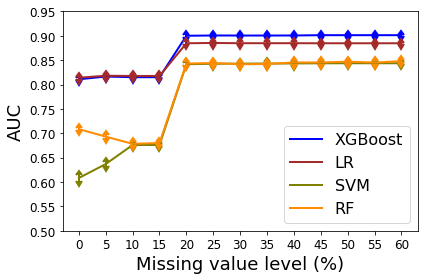

In [17]:
plt.figure(figsize=(6,4))
import numpy as np
import matplotlib.pyplot as plt

#plt.subplot(325)
x = [0,5,10,15,20,25,30,35,40,45,50,55,60]

RF_Mean_Mode = df_AUC_rf.mean()
RF_Mean_Mode_etd_er = df_AUC_rf.sem(axis = 0)
LR_Mean_Mode = df_AUC_lr.mean()
LR_Mean_Mode_etd_er = df_AUC_lr.sem(axis = 0)
SVM_Mean_Mode = df_AUC_svm.mean()
SVM_Mean_Mode_etd_er = df_AUC_svm.sem(axis = 0)
XGB_Mean_Mode = df_AUC_xgb.mean()
XGB_Mean_Mode_etd_er = df_AUC_xgb.sem(axis = 0)

plt.plot(x, XGB_Mean_Mode,'b-',label='XGB_Mean_Mode',linewidth=2,markersize = 10)
plt.errorbar(x, XGB_Mean_Mode, yerr=XGB_Mean_Mode_etd_er, fmt='',linestyle='None', ecolor='b', linewidth=2,capthick=2, uplims=True, lolims=True)

plt.plot(x, LR_Mean_Mode,'-',color ='brown',label='LR_Mean_Mode',linewidth=2,markersize = 10)
plt.errorbar(x, LR_Mean_Mode, yerr=LR_Mean_Mode_etd_er, fmt='',linestyle='None', ecolor='brown',linewidth=2, capthick=2, uplims=True, lolims=True)

plt.plot(x, SVM_Mean_Mode,'-',color ='olive',label='SVM_Mean_Mode',linewidth=2,markersize = 10)
plt.errorbar(x, SVM_Mean_Mode, yerr=SVM_Mean_Mode_etd_er, fmt='',linestyle='None', ecolor='olive', linewidth=2,capthick=2, uplims=True, lolims=True)

plt.plot(x, RF_Mean_Mode,'-',color = 'darkorange',label='RF_Mean_Mode',linewidth=2,markersize = 10)
plt.errorbar(x, RF_Mean_Mode, yerr=RF_Mean_Mode_etd_er, fmt='',linestyle='None', ecolor='darkorange',linewidth=2, capthick=2,uplims=True, lolims=True)

plt.xlabel('Missing value level (%)', fontsize=18)
plt.xticks(np.arange(0, 61, step=5),fontsize=12)
plt.yticks( fontsize=12)
plt.ylabel('AUC', fontsize=18)
plt.ylim([0.50,0.95])
plt.legend(( 'XGBoost','LR', 'SVM','RF'), loc='lower right', fontsize=16)

plt.tight_layout()
# save the figure in tiff file
plt.savefig("Figure_2A.tiff", dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"})